# CS5242 Final Project
> Dataset and rules

### Rules
- No additional data for training is allowed **except the pretrained models over ImageNet**. You need to submit your code for verification.
- Any cheating will result in 0 score. For example, joining the competition with multiple accounts; or using additional data.
- The dataset can only be used for this Kaggle competition. Distribution or using it for other purposes is not allowed.
- Set the teamname with your student number and your name, e.g., `A01234X_Bob`; Once your group is merged, rename the group to `Group_ID`, e.g., `Group_01`.
- Penalty will be applied if you merge into the group after the deadline (13 Oct, 17:00) or using improper group name. 10% off per day.

**Deadline**: 3 Nov, 17:00 <br>
**Report deadline**: 10 Nov, 17:00 <br>

### Imports and Settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from skimage.io import imread
from os import path

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
# for plotting figures (report)
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (3,3) # use larger for presentation
matplotlib.rcParams['font.size']= 9 # use 14 for presentation

In [3]:
# check for CUDA device and set default dtype
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'device: {device}\ndtype: {dtype}')

device: cpu
dtype: torch.float32


## Training Dataset (before Train/Val split)

In [4]:
# Paths to training dataset and labels (before Train/Val split)
train_csv = path.join('./datasets','train_label.csv')
train_data_path = path.join('./datasets','train_image','train_image')

- There are three classes (types of labels): {0, 1, 2}
- Input images are 8-bit (per channel) RGB images

Y: (1164, 2)
Y classes: [0 1 2]


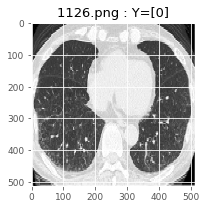

Check dtypes and size of sample input images:
 image # 1126-> shape(HxWxC): (512, 512, 3)| dtype: uint8
 image #  860-> shape(HxWxC): (512, 512, 3)| dtype: uint8
 image # 1130-> shape(HxWxC): (512, 512, 3)| dtype: uint8
 image # 1095-> shape(HxWxC): (512, 512, 3)| dtype: uint8
 image # 1044-> shape(HxWxC): (512, 512, 3)| dtype: uint8


In [5]:
# Training dataset labels
Y_train_np = pd.read_csv(train_csv).values
# We have three types of labels: {0, 1, 2},
# and 1164 samples (training dataset, before splitting into train/val data)
print('Y:',Y_train_np.shape)
print('Y classes:',np.unique(Y_train_np[:,1]))

np.random.seed(42) # RNG seed for consistency
ids = np.random.randint(0,Y_train_np.shape[0],size=(5,))

m=ids[0]
x_0 = imread(path.join(train_data_path,f'{m}.png'))
plt.imshow(x_0)
plt.title(f'{m}.png : Y={Y_train_np[Y_train_np[:,0]==m,1]}');
plt.show()
# dtype and shape of input images
print('Check dtypes and size of sample input images:')
for m in ids:
    x_0 = imread(path.join(train_data_path,f'{m}.png'))
    print(f' image #{m:5d}-> shape(HxWxC): {x_0.shape}| dtype: {x_0.dtype}') # HxWxC
# output was "shape(HxWxC): (512, 512, 3)| dtype: uint8"

## Using Pytorch Dataset Class (implemented in datautils.py)

In [168]:
from datautils import LungDataset
from torchvision import transforms as T, utils

toPIL = T.ToPILImage()
transform = T.Compose([T.ToPILImage(),
                       T.Resize(224),
                       T.ToTensor(), 
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dataset = LungDataset(train_csv, train_data_path, transform=transform)

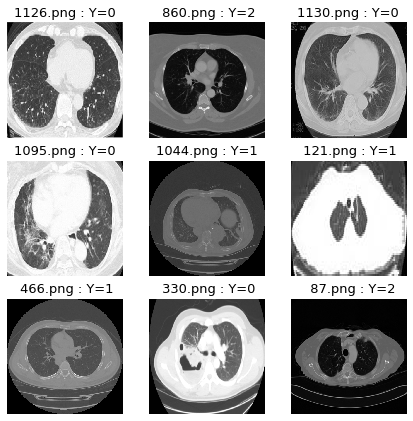

In [7]:
np.random.seed(42) # RNG seed for consistency

_, axs = plt.subplots(ncols=3,nrows=3,figsize=(7.2,7.2))
ids = np.random.randint(0,len(train_dataset),size=(axs.size,))
for ax, m in zip(axs.ravel(),ids):
    sample = train_dataset[m]
    ax.imshow(sample['image'])
    ax.set_title(f'{m:4d}.png : Y={sample["label"]}')
    ax.axis('off')
plt.show()

- I will split the original training data into $80\% / 20\%$ train/val datasets

In [164]:
train_size = len(train_dataset)*85//100
val_size = len(train_dataset)-train_size
train_data, val_data= torch.utils.data.random_split(train_dataset,[train_size,val_size],
                                                generator=torch.Generator().manual_seed(42))
print(f'Training: {len(train_data)}; Validation: {len(val_data)}')

Training: 989; Validation: 175


In [165]:
trainloader = DataLoader(train_data, batch_size=4,shuffle=True, num_workers=0)

In [195]:
class BatchUnnorm():
    '''Convert normalized batch to original values.'''
    def __init__(self,mu=[0.229, 0.224, 0.225],sd=[0.485, 0.456, 0.406]):
        '''
        mu: list of means (3 elements, one for each channel)
        sd: list of standard deviations (size same as "mu")
        Default "mu" and "sd" are for ImageNet dataset.
        '''
        self.mu = torch.tensor(mu).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        self.sd = torch.tensor(sd).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    def __call__(self,img_batch):
        '''Input: batch of images NxCxHxW'''
        return img_batch*self.sd+self.mu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 0: x torch.Size([4, 3, 224, 224]); Labels [1, 1, 2, 2]


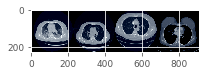

In [207]:
for k, elem in enumerate(trainloader):
    print(f"Sample {k}: x {elem['image'].shape}; Labels {elem['label'].tolist()}")
    grid = utils.make_grid(unnormb(elem['image']))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()
    break